In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import json

In [3]:
def apply_watershed(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]  # Mark boundaries in red
    mask = (markers > 1).astype(np.uint8) * 255  # Convert regions into binary mask
    return mask

In [4]:
def apply_otsu(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

In [5]:
def apply_kmeans(image, K=3):
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((image.shape))
    gray = cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    return binary

In [6]:
def apply_canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    return edges

In [7]:
def apply_adaptive_threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 11, 2)
    return adaptive_thresh

In [8]:
def apply_mean_shift(image):
    mean_shift = cv2.pyrMeanShiftFiltering(image, sp=21, sr=41)
    mean_shift_gray = cv2.cvtColor(mean_shift, cv2.COLOR_BGR2GRAY)
    _, mean_shift_mask = cv2.threshold(mean_shift_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mean_shift_mask


In [9]:
def apply_log(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    log_edges = cv2.Laplacian(gray, cv2.CV_64F)
    log_edges = np.uint8(np.absolute(log_edges))
    _, log_mask = cv2.threshold(log_edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return log_mask

In [10]:
def ensure_foreground_white(mask):
    if np.sum(mask == 255) < np.sum(mask == 0):
        return cv2.bitwise_not(mask)
    return mask

def segment_image(img):
    # Original methods
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab)

    _, otsu_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    otsu_mask = ensure_foreground_white(otsu_mask)

    a_thresh = cv2.adaptiveThreshold(a_channel, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY_INV, 11, 2)
    a_thresh = ensure_foreground_white(a_thresh)

    Z = img.reshape((-1, 3))
    Z = np.float32(Z)
    _, label, center = cv2.kmeans(Z, 2, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0), 10, cv2.KMEANS_RANDOM_CENTERS)
    clustered_img = center[label.flatten()].reshape(img.shape)
    clustered_gray = cv2.cvtColor(np.uint8(clustered_img), cv2.COLOR_BGR2GRAY)
    _, kmeans_mask = cv2.threshold(clustered_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kmeans_mask = ensure_foreground_white(kmeans_mask)

    edges = cv2.Canny(gray, 50, 150)
    kernel = np.ones((3, 3), np.uint8)
    canny_mask = cv2.dilate(edges, kernel, iterations=1)
    canny_mask = cv2.morphologyEx(canny_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    canny_mask = ensure_foreground_white(canny_mask)

    dist_transform = cv2.distanceTransform(otsu_mask, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(cv2.dilate(otsu_mask, kernel, iterations=3), sure_fg)
    markers = cv2.connectedComponents(sure_fg)[1] + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(img, markers)
    watershed_mask = np.zeros_like(gray)
    watershed_mask[markers > 1] = 255
    watershed_mask = ensure_foreground_white(watershed_mask)

    mean_shift_mask = ensure_foreground_white(apply_mean_shift(img))
    log_mask = ensure_foreground_white(apply_log(img))

    # Combine all masks into a list for voting
    masks = [otsu_mask, a_thresh, kmeans_mask, canny_mask, watershed_mask, mean_shift_mask, log_mask]
    stacked_masks = np.stack(masks, axis=2)

    # Voting: count votes for foreground (white) in each pixel
    vote_counts = np.sum(stacked_masks == 255, axis=2)
    vote_threshold = 4  # Majority vote threshold (adjust based on number of methods)
    final_mask = np.where(vote_counts >= vote_threshold, 255, 0).astype(np.uint8)

    # Final smoothing with Gaussian blur
    final_mask = cv2.GaussianBlur(final_mask, (3, 3), 0)

    return final_mask

In [11]:
def load_ground_truth_mask(json_file, image_shape):
    with open(json_file, 'r') as f:
        annotations = json.load(f)

    # Initialize an empty mask
    ground_truth_mask = np.zeros(image_shape[:2], dtype=np.uint8)

    # Iterate through each annotation and draw the polygon on the mask
    for annotation in annotations:
        segmentation = annotation['segmentation']
        for poly in segmentation:
            # Convert the polygon points to integer pixel coordinates
            polygon = np.array(poly, dtype=np.int32).reshape((-1, 2))
            cv2.fillPoly(ground_truth_mask, [polygon], 1)  # Fill the polygon with 1 for foreground

    ground_truth_mask *= 255  # Scale to 255 for visualization and compatibility with other masks
    return ground_truth_mask


In [12]:
def invert_mask(mask):
    return cv2.bitwise_not(mask)

def calculate_iou(segmentation, ground_truth):
    # Calculate IoU for original mask
    intersection = np.logical_and(segmentation, ground_truth)
    union = np.logical_or(segmentation, ground_truth)
    iou_original = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0

    # Calculate IoU for inverted mask
    inverted_segmentation = invert_mask(segmentation)
    intersection_inverted = np.logical_and(inverted_segmentation, ground_truth)
    union_inverted = np.logical_or(inverted_segmentation, ground_truth)
    iou_inverted = np.sum(intersection_inverted) / np.sum(union_inverted) if np.sum(union_inverted) != 0 else 0

    # Return the higher IoU score
    return max(iou_original, iou_inverted)


IoU Scores:
Watershed: 0.3898
Otsu's Thresholding: 0.5435
k-means Clustering: 0.5315
Canny Edge Detection: 0.3619
Adaptive Thresholding: 0.3294
Mean Shift: 0.5540
Laplacian of Gaussian: 0.3774
Our Method: 0.5632


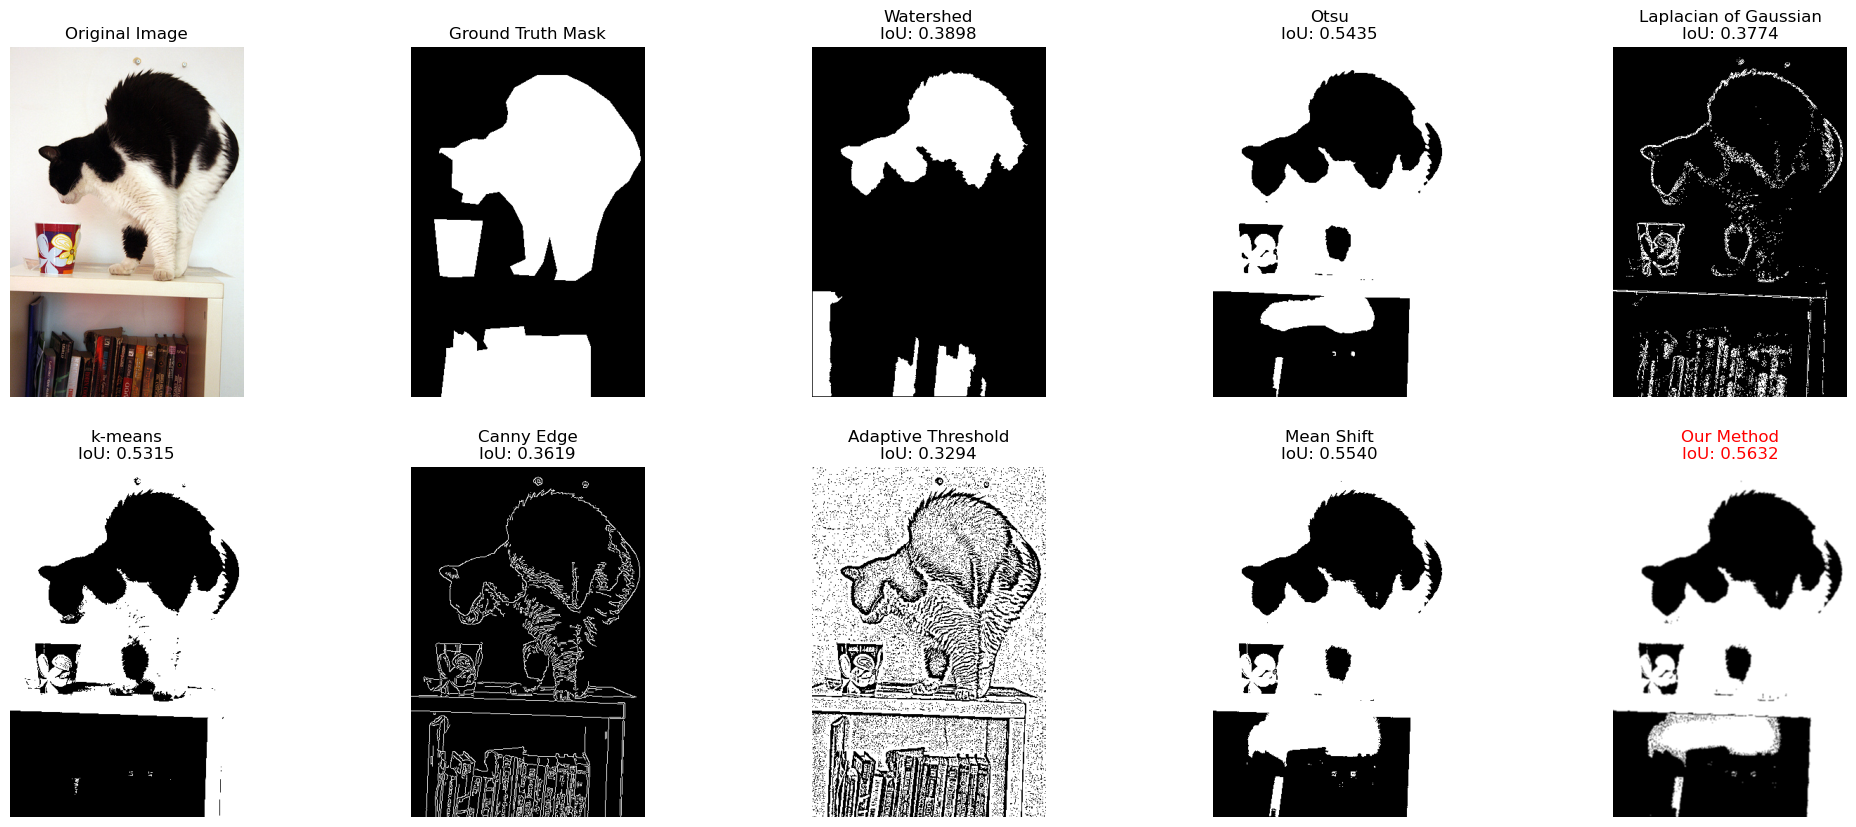

In [13]:
# Load the original image
img = cv2.imread('000000542054.jpg')  # Make sure this path is correct

# Load the ground truth mask from JSON
ground_truth = load_ground_truth_mask('annotations_542054.json', img.shape)

# Apply segmentation algorithms
watershed_result = apply_watershed(img.copy())
otsu_result = apply_otsu(img.copy())
kmeans_result = apply_kmeans(img.copy())
canny_result = apply_canny(img.copy())
adaptive_thresh_result = apply_adaptive_threshold(img.copy())
mean_shift_result = apply_mean_shift(img.copy())
log_result = apply_log(img.copy())
our_result = segment_image(img.copy())



# Calculate IoU scores
iou_watershed = calculate_iou(watershed_result, ground_truth)
iou_otsu = calculate_iou(otsu_result, ground_truth)
iou_kmeans = calculate_iou(kmeans_result, ground_truth)
iou_canny = calculate_iou(canny_result, ground_truth)
iou_adaptive_thresh = calculate_iou(adaptive_thresh_result, ground_truth)
iou_mean_shift = calculate_iou(mean_shift_result, ground_truth)
iou_log = calculate_iou(log_result, ground_truth)
iou_our = calculate_iou(our_result, ground_truth)

# Print IoU scores
print("IoU Scores:")
print(f"Watershed: {iou_watershed:.4f}")
print(f"Otsu's Thresholding: {iou_otsu:.4f}")
print(f"k-means Clustering: {iou_kmeans:.4f}")
print(f"Canny Edge Detection: {iou_canny:.4f}")
print(f"Adaptive Thresholding: {iou_adaptive_thresh:.4f}")
print(f"Mean Shift: {iou_mean_shift:.4f}")
print(f"Laplacian of Gaussian: {iou_log:.4f}")
print(f"Our Method: {iou_our:.4f}")

fig, axs = plt.subplots(2, 5, figsize=(25, 10))

# Original image
axs[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

# Ground truth
axs[0, 1].imshow(ground_truth, cmap='gray')
axs[0, 1].set_title('Ground Truth Mask')
axs[0, 1].axis('off')

# Watershed
axs[0, 2].imshow(watershed_result, cmap='gray')
axs[0, 2].set_title(f'Watershed\nIoU: {iou_watershed:.4f}')
axs[0, 2].axis('off')

# Otsu's Thresholding
axs[0, 3].imshow(otsu_result, cmap='gray')
axs[0, 3].set_title(f'Otsu\nIoU: {iou_otsu:.4f}')
axs[0, 3].axis('off')

# k-means Clustering
axs[1, 0].imshow(kmeans_result, cmap='gray')
axs[1, 0].set_title(f'k-means\nIoU: {iou_kmeans:.4f}')
axs[1, 0].axis('off')

# Canny Edge Detection
axs[1, 1].imshow(canny_result, cmap='gray')
axs[1, 1].set_title(f'Canny Edge\nIoU: {iou_canny:.4f}')
axs[1, 1].axis('off')

# Adaptive Thresholding
axs[1, 2].imshow(adaptive_thresh_result, cmap='gray')
axs[1, 2].set_title(f'Adaptive Threshold\nIoU: {iou_adaptive_thresh:.4f}')
axs[1, 2].axis('off')

# Mean Shift
axs[1, 3].imshow(mean_shift_result, cmap='gray')
axs[1, 3].set_title(f'Mean Shift\nIoU: {iou_mean_shift:.4f}')
axs[1, 3].axis('off')

# Laplacian of Gaussian
axs[0, 4].imshow(log_result, cmap='gray')
axs[0, 4].set_title(f'Laplacian of Gaussian\nIoU: {iou_log:.4f}')
axs[0, 4].axis('off')

# Our Method
axs[1, 4].imshow(our_result, cmap='gray')
axs[1, 4].set_title(f'Our Method\nIoU: {iou_our:.4f}', color='red')
axs[1, 4].axis('off')

plt.show()